# No More Alzheimer's Disease

## General Data Processing

### Data Downloading

In [80]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score
from timeit import default_timer as timer
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

### Data Pre-Processing

Each necessary file is downloaded, unnecessary fields are removed and labels are assigned.

In [5]:
'''This function reads and does some pre-processing for the data files provided.'''

ugot = pd.read_csv("Data/Plasma/UGOTPTAU181_06_18_20_27Nov2023.csv")
# Read the labels that will be used for both of the files
labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]


#-------------------------UGOT------------------------------------------------------------------------
# Now merge these two files and remove any rows that have null values
ugot = pd.merge(ugot, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna(subset=['RID', 'PLASMAPTAU181', 'DX'])
# Update Stamp is not relevant for this test
ugot.drop(['update_stamp', 'VISCODE', 'VISCODE2', 'COMMENT', 'VID', 'EXAMDATE'], axis=1, inplace=True)
# This puts the labels in the same format used for the tests
ugot = ugot.replace("Dementia", "AD").replace("CN", "SCD").reset_index(drop=True)
ugot.to_csv("Data/ProcessedData/UGOT.csv", index=False)

# -------------------------UPENN----------------------------------------------------------------------
upenn = pd.read_csv("Data/Plasma/UPENNPLASMA_27Nov2023.csv")
upenn = pd.merge(upenn, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna()
upenn.drop(['update_stamp', 'VISCODE'], axis=1, inplace=True)
# This puts the labels in the same format used for the tests
upenn = upenn.replace("Dementia", "AD").replace("CN", "SCD").reset_index(drop=True)
upenn.to_csv("Data/ProcessedData/UPENN.csv", index=False)

# --------------------------ADNI_MERGE-----------------------------------------------------------------
adni_merge = pd.read_csv("Data/ADNIMERGE_15Jun2023.csv")
adni_merge = adni_merge.loc[:, ~adni_merge.columns.str.endswith('_bl')]
adni_merge = adni_merge.loc[:, ['RID', 'DX', 'MMSE', 'AGE', 'PTAU', 'TAU', 'ABETA']]
regex_pattern = r'[<>](\d+)'

# This applies to all columns
adni_merge = adni_merge.apply(lambda col: col.astype(str).str.replace(regex_pattern, r'\1', regex=True))
adni_merge = adni_merge.replace('nan', np.nan).dropna()

#change to required format
adni_merge = adni_merge.replace("CN", "SCD").replace("Dementia", "AD")
adni_merge.to_csv("Data/ProcessedData/ADNIMerge.csv")

# --------------------------PLASMA_ABETA_PROJECT--------------------------------------------------------
p_ab = pd.read_csv('Data/Plasma/PLASMA_ABETA_PROJECT_ADX_VUMC_27Nov2023.csv')
# Drop the VISCODE column and replace it with VISCODE2 (REFERENCE :: https://groups.google.com/g/adni-data/c/Dx_Rgge_XB0)
p_ab.drop('VISCODE', inplace=True, axis=1)
p_ab.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
p_ab = pd.merge(p_ab, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna()
p_ab = p_ab.loc[:, ['RID', 'DX', 'SEQ', 'NF_LIGHT', 'ABETA42', 'ABETA40', 'GFAP']]
p_ab = p_ab.replace("CN", "SCD").replace('Dementia', 'AD')


p_ab.to_csv('Data/ProcessedData/Plasma_AB.csv')


/var/folders/9h/tqk_65w50d95gtyf68q0hv880000gn/T/ipykernel_82133/1755160768.py:5: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]
/var/folders/9h/tqk_65w50d95gtyf68q0hv880000gn/T/ipykernel_82133/1755160768.py:26: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  adni_merge = pd.read_csv("Data/ADNIMERGE_15Jun2023.csv")


In [6]:
# Read each of the files and select the useful fields

blen = pd.read_csv('Data/Plasma/ADNI_BLENNOWPLASMANFL_10_03_18_27Nov2023.csv')[['RID', 'VISCODE2', 'PLASMA_NFL']]
fnih = pd.read_csv('Data/Plasma/FNIH_PLASMA_PTAU181_PROJECT_27Nov2023.csv')[['RID', 'VISCODE2', 'PTAU_181']]
#??????
# fuji = pd.read_csv('Data/Plasma/FUJIREBIOABETAPLASMA_06Dec2023.csv')[['RID', 'VISCODE2', 'PTAU_181']]
#??????
plasmaab = pd.read_csv('Data/Plasma/PLASMA_ABETA_PROJECT_ADX_VUMC_27Nov2023.csv')[['RID', 'VISCODE2', 'NF_LIGHT', 'ABETA42', 'ABETA40', 'GFAP']]
ugot = pd.read_csv('Data/Plasma/UGOTPTAU181_06_18_20_27Nov2023.csv')[['RID', 'VISCODE2', 'PLASMAPTAU181']] # RENAME PTAU
dian = pd.read_csv('Data/Plasma/UPENNPLASMA_27Nov2023.csv')[['RID', 'VISCODE', 'AB40', 'AB42']]

# Rename all of the VISCODE2 => VISCODE for merging (REFERENCE :: https://groups.google.com/g/adni-data/c/Dx_Rgge_XB0)
blen.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
fnih.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
plasmaab.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
ugot.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)

# Rename PLASMAPTAU181 => PTAU_181 for merging
ugot.rename(columns={'PLASMAPTAU181' : 'PTAU_181'}, inplace=True)

# Attempt to merge
df = pd.merge(blen, fnih, on=['RID', 'VISCODE'], how='outer')
df = pd.merge(df, plasmaab, on=['RID', 'VISCODE'], how='outer')
df = pd.merge(df, ugot, on=['RID', 'VISCODE'], how='outer')
df = pd.merge(df, dian, on=['RID', 'VISCODE'], how='outer')

# Now assign a label to each item
labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]
df = pd.merge(df, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').replace('CN', 'SCD').replace('Dementia', 'AD')

# Remove any items that couldn't be classified
df = df.dropna(subset=['DX'])
df.drop("VISCODE", inplace=True, axis=1)

# Store the data to a .csv for easier analysis
df.to_csv('Data/ProcessedData/ALL_PLASMA_MERGED.csv')

# Now select the plasma biomarkers required and remove any ones with null fields

df = df[['PTAU_181_x', 'NF_LIGHT', 'ABETA42', 'ABETA40', 'GFAP', 'DX']].dropna()
df.to_csv('Data/ProcessedData/PLASMA_MERGED.csv', index=False)

/var/folders/9h/tqk_65w50d95gtyf68q0hv880000gn/T/ipykernel_82133/2208692363.py:28: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]


### General Functions

In [7]:
def getXy(df):
    '''
    Seperate the label from the feature data.
    
    Args : 
        df (DataFrame) : The data to be seperated
    Returns :
        X (DataFrame) : The feature data.
        y (list) : The labels associated.'''
    
    # Independant
    X = df.drop("DX", axis=1).values
    # Dependant
    y = df["DX"].values

    return X, y

### SVM Approach

Use Cross Validation to find what parameters suit this problem the best

In [8]:
svm = SVC()

X, y = getXy(pd.read_csv('Data/ProcessedData/PLASMA_MERGED.csv'))
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# These are the parameters that will be trialled
param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel' : ['linear', 'poly', 'rbf'],
    'degree' : [2, 3, 4],
    'decision_function_shape' : ['ovr', 'ovo']
}

# Runs every possible combination and gets the best
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Display the best parameters and best accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 100, 'decision_function_shape': 'ovr', 'degree': 2, 'kernel': 'rbf'}
Best Score:  0.5841523049897925


Text(0, 0.5, 'Accuracy')

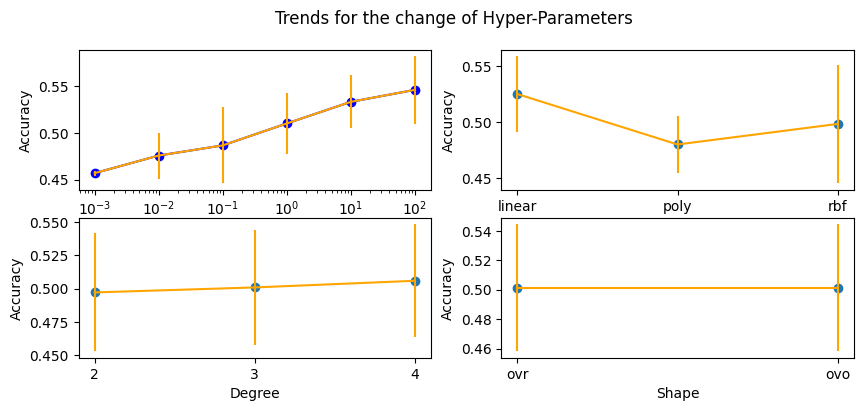

In [9]:
results = pd.DataFrame(grid_search.cv_results_)

fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))
fig.suptitle("Trends for the change of Hyper-Parameters")

c = results.groupby('param_C')['mean_test_score']
plt.subplot(2, 2, 1)
plt.plot(param_grid['C'], c.mean(), color='blue', marker='o')
plt.errorbar(param_grid['C'], c.mean(), yerr=c.std(), color='orange')
plt.xlabel("C value")
plt.ylabel("Accuracy")
plt.xscale('log')

kernel = results.groupby('param_kernel')['mean_test_score']
plt.subplot(2, 2, 2)
plt.scatter(param_grid['kernel'], kernel.mean())
plt.errorbar(param_grid['kernel'], kernel.mean(), yerr=kernel.std(), color='orange')
plt.xlabel("Kernel")
plt.ylabel("Accuracy")

degrees = results.groupby('param_degree')['mean_test_score']
plt.subplot(2, 2, 3)
plt.scatter(['2', '3', '4'], degrees.mean())
plt.errorbar(['2', '3', '4'], degrees.mean(), yerr=degrees.std(), color='orange')
plt.xlabel("Degree")
plt.ylabel("Accuracy")

shape = results.groupby('param_decision_function_shape')['mean_test_score']
plt.subplot(2, 2, 4)
plt.scatter(param_grid['decision_function_shape'], shape.mean())
plt.errorbar(param_grid['decision_function_shape'], shape.mean(), yerr=shape.std(), color='orange')
plt.xlabel("Shape")
plt.ylabel("Accuracy")

# TODO :: Comment and fix the fact that there is no x label for top grpahs
# TODO :: See if the loss function cab be printed

## Test for these hyper-parameters

In [16]:
print("Best Parameters " + str(grid_search.best_params_))

# Creates a SVC object with the best parameters selected.
test_classifier = SVC(
    C = grid_search.best_params_['C'],
    decision_function_shape = grid_search.best_params_['decision_function_shape'],
    degree = grid_search.best_params_['degree'],
    kernel = grid_search.best_params_['kernel']
)

# Runs a test to find the accuracy of the model
test_classifier.fit(X_train, y_train)

y_testresult = test_classifier.predict(X_test)

print("Accuracy is " + str(accuracy_score(y_test, y_testresult)))
print("Recall was " + str(recall_score(y_test, y_testresult, average=None)))

Best Parameters {'C': 100, 'decision_function_shape': 'ovr', 'degree': 2, 'kernel': 'rbf'}
Accuracy is 0.6555555555555556
Recall was [0.46153846 0.81578947 0.56410256]


### Binary Decision Tree SVM Classifier

# Random Forest Approach

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [31]:
# Create the test object
rf = RandomForestClassifier()

# Re-read the dataframe
df = pd.read_csv("Data/ProcessedData/PLASMA_MERGED.csv")

# Split for a 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now we create the grid of params we need to test
param_grid = {
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'bootstrap' : [True, False],
    'class_weight' : ['balanced', 'balanced_subsample']
}

# Create the test Object and fit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='accuracy')

In [32]:
print(grid_search.best_params_)
grid_search.best_score_

{'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 200}


0.9830983240753929

Text(0, 0.5, 'Accuracy')

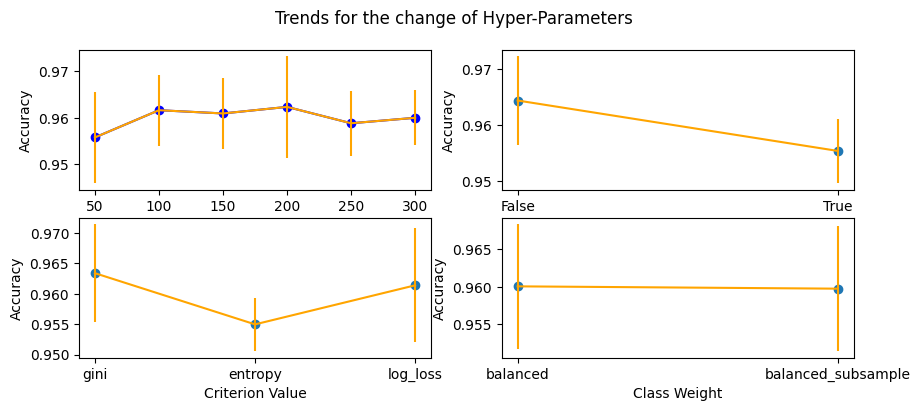

In [40]:
# Plot the results as well as the Standard Dev. of each with the changing parameters

results = pd.DataFrame(grid_search.cv_results_)

fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))
fig.suptitle("Trends for the change of Hyper-Parameters")

n = results.groupby('param_n_estimators')['mean_test_score']
plt.subplot(2, 2, 1)
plt.plot(param_grid['n_estimators'], n.mean(), color='blue', marker='o')
plt.errorbar(param_grid['n_estimators'], n.mean(), yerr=n.std(), color='orange')
plt.xlabel("Estimators Amount")
plt.ylabel("Accuracy")

bs = results.groupby('param_bootstrap')['mean_test_score']
plt.subplot(2, 2, 2)
plt.scatter(['False', 'True'], bs.mean())
plt.errorbar(['False', 'True'], bs.mean(), yerr=bs.std(), color='orange')
plt.xlabel("Bootstrapping Value")
plt.ylabel("Accuracy")

c = results.groupby('param_criterion')['mean_test_score']
plt.subplot(2, 2, 3)
plt.scatter(param_grid['criterion'], c.mean())
plt.errorbar(param_grid['criterion'], c.mean(), yerr=c.std(), color='orange')
plt.xlabel("Criterion Value")
plt.ylabel("Accuracy")

cw = results.groupby('param_class_weight')['mean_test_score']
plt.subplot(2, 2, 4)
plt.scatter(param_grid['class_weight'], cw.mean())
plt.errorbar(param_grid['class_weight'], cw.mean(), yerr=cw.std(), color='orange')
plt.xlabel("Class Weight")
plt.ylabel("Accuracy")

In [277]:
print("Best Parameters " + str(grid_search.best_params_))

# Creates a SVC object with the best parameters selected.
test_classifier = RandomForestClassifier(
    bootstrap = grid_search.best_params_['bootstrap'],
    n_estimators = grid_search.best_params_['n_estimators'],
    class_weight = grid_search.best_params_['class_weight'],
    criterion = grid_search.best_params_['criterion'],
    random_state = 42 # Ensure reprodcibility
)

# Runs a test to find the accuracy of the model
test_classifier.fit(X_train, y_train)

y_testresult = test_classifier.predict(X_test)

# Print the test results
print("Accuracy is " + str(accuracy_score(y_test, y_testresult)))
# Get the recall and metrics for each class
recall = list(recall_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))
precision = list(precision_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))
f1 = list(f1_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))

data = [["Recall"] + recall]
data.append(["Precision"] + precision)
data.append(["F1 Score"] + f1)

labels = sorted(set(y_test))  # Gets the order of the labels



table = tabulate(data, ['', 'SCD', 'MCI', 'AD'], tablefmt="grid")
print(table)

# print(confusion_matrix(y_test, y_testresult, labels=['SCD', 'MCI', 'AD']))

# Maybe BC there is the most MCI

Best Parameters {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 200}
Accuracy is 0.9555555555555556
+-----------+----------+-------+----------+
|           |      SCD |   MCI |       AD |
+===========+==========+=======+==========+
| Recall    | 0.897436 |     1 | 1        |
+-----------+----------+-------+----------+
| Precision | 1        |     1 | 0.764706 |
+-----------+----------+-------+----------+
| F1 Score  | 0.945946 |     1 | 0.866667 |
+-----------+----------+-------+----------+


## Handling the minority class of AD

Upon inspection of the data set, AD is a very under-represented group in the dataset.

### Data distribution visualisation

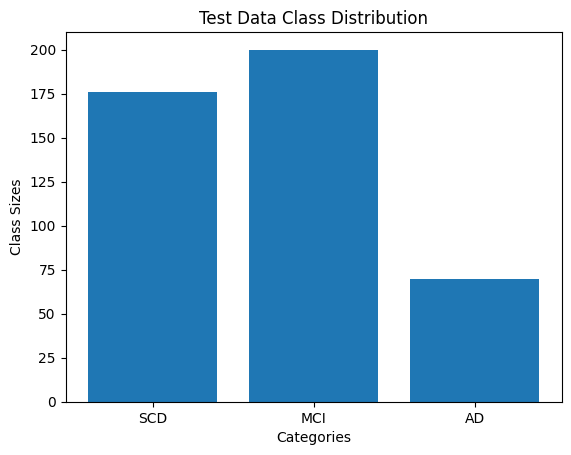

In [43]:
# Read the dataset
df = pd.read_csv("Data/ProcessedData/PLASMA_MERGED.csv")

# Display the size of each of the groups
sizes = [len(df[df["DX"] == "SCD"]), len(df[df["DX"] == "MCI"]), len(df[df["DX"] == "AD"])]

# Represent as a graph
categories = ["SCD", "MCI", "AD"]
plt.bar(categories, sizes)
plt.xlabel('Categories')
plt.ylabel('Class Sizes')
plt.title('Test Data Class Distribution')
plt.show()


### SMOTE Oversampling

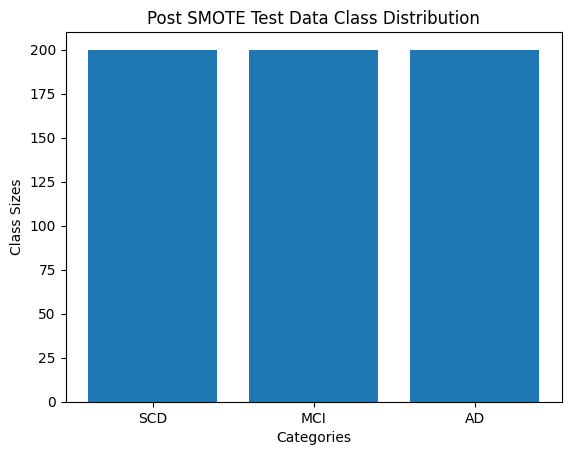

In [61]:
# Use SMOTE :: SOURCE (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8125820)
    # Extra complexity not necessary for this case
# How to implement SMOTE (https://towardsdatascience.com/applying-smote-for-class-imbalance-with-just-a-few-lines-of-code-python-cdf603e58688)

sm = SMOTE(random_state=42)

X, y = getXy(df)

X, y = sm.fit_resample(X, y)


# Display the size of each of the groups
sizes = [np.count_nonzero(y == "SCD"), np.count_nonzero(y == "MCI"), np.count_nonzero(y == "AD")]

# Represent as a graph
categoroies = ["SCD", "MCI", "AD"]
plt.bar(categoroies, sizes)
plt.xlabel('Categories')
plt.ylabel('Class Sizes')
plt.title('Post SMOTE Test Data Class Distribution')
plt.show()


## Test Data Model

In [311]:
# This re-associates the features with the labels
df = pd.DataFrame(data=np.column_stack((X, y)), columns=list(df.drop("DX", axis=1).columns) + ["DX"])

# Get X and y
X, y = getXy(df)

print("Best Parameters " + str(grid_search.best_params_))

# Split for a 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Creates a SVC object with the best parameters selected.
test_classifier = RandomForestClassifier(
    bootstrap = grid_search.best_params_['bootstrap'],
    n_estimators = grid_search.best_params_['n_estimators'],
    class_weight = grid_search.best_params_['class_weight'],
    criterion = grid_search.best_params_['criterion']
)

# Runs a test to find the accuracy of the model
test_classifier.fit(X_train, y_train)

y_testresult = test_classifier.predict(X_test)

# Print the test results
print("Accuracy is " + str(accuracy_score(y_test, y_testresult)))



Best Parameters {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 200}
Accuracy is 0.9555555555555556


In [63]:
# NOTE : This is copied word for word from 'bdt_rf' but modified return values
def bdt_rf_v2(file_path=None, df=None):

    '''
        Perform the Binary Decision Tree RF classification method. (But returns the true and predicted classes)
        
        Args :
            file_path (String) : Path to the data
            df (DataFrame) : Passes in the dataframe if there is no file path
        Returns :
            y_pred (np Array) : Returns the predicted labels
            y_true (np Array) : Returns the true labels
    '''
    if file_path != None:
        df = pd.read_csv(file_path)
    
    # Now seperate the labels
    SCD, MCI, AD = get_different_classes(df)
    # get the test data required, leave training data
    SCD, MCI, AD, TestData = split_test_data(SCD, MCI, AD)
    

    # seperate the labels and the data features
    X_test, y_test = getXy(TestData)

    # Concatenate MCI
    MCIoAD = [MCI, AD]
    MCIoAD = pd.concat(MCIoAD)
    # Map to the same class
    MCIoAD = MCIoAD.replace("MCI", "MCIoAD").replace("AD", "MCIoAD")

    # Test to perform the first step of the DT
    SCDMCIAD = construct_rf(SCD, MCIoAD)
    # SVM for the second level of the BDT
    MCIAD = construct_rf(MCI, AD)

    # Perform the test for the first level of BDT
    SCDoMCIAD = test_rf(SCDMCIAD, X_test)

    # Now run entire set through the MCI, AD classifier. 
    # However, only the non-SCD items in the previous test will be used
    MCIoAD = test_rf(MCIAD, X_test)

    # Now colalate the results together taking the two classifiers into account
    results = []
    
    for i in range(len(SCDoMCIAD)):
        if SCDoMCIAD[i] == 'SCD':
            results.append('SCD')
        else:
            # Adds the result of the second level
            results.append(MCIoAD[i])

    return list(results), list(y_test)


In [64]:
# More performance metrics on the SMOTE data
y_pred, y_true = bdt_rf_v2(df=df)

# Map string to a number representing the class
maps = {'SCD': 0, 'MCI': 1, 'AD': 2}
y_pred = [maps[item] for item in y_pred]
y_true = [maps[item] for item in y_true]

print(y_pred)
print(y_true)

# Get the AUC value
auc_roc_per_class = roc_auc_score(y_true, y_pred, multi_class='ovr')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


AxisError: axis 1 is out of bounds for array of dimension 1

## Tuning Hyper-parameters of RF

## Feature Selection

In [ ]:
# TODO :: Maybe make different files with different biomarkers selected
    # TODO :: Also do feature selection.
# TODO :: Tune hyper-parameters of RF
# TODO :: Make More Results
    # TODO :: Look into AUC and specificity results
# TODO :: Look into the structure of the BDT. i.e. what classes put at top.
# TODO :: Minority Class -> Feature Selection -> Tune Hyperparameters

# NEW TODO :: Data Processing (SMOTE) -> Get Best Singular Clasifier (Tune etc.) / Choose Between SVM and RF -> Feature Selection